In [1]:
import numpy as np
import pandas as pd

# ----------------------------
# 0) 工具：把价格变成月收益（ME）
# ----------------------------
def to_monthly_returns(price_m: pd.Series) -> pd.Series:
    p = price_m.dropna().copy()
    p.index = pd.DatetimeIndex(p.index).to_period("M").to_timestamp("M")
    p = p[~p.index.duplicated(keep="last")].sort_index()
    return p.pct_change()

# ----------------------------
# 1) 口径A：公历月份作为“流月proxy”
# ----------------------------
def label_gregorian_month(idx: pd.DatetimeIndex) -> pd.Series:
    idx = pd.DatetimeIndex(idx)
    return pd.Series(idx.month, index=idx, name="greg_month")  # 1..12

# ----------------------------
# 2) 暴涨定义 + 分组统计（含 Bayes 概率）
# ----------------------------
def summarize_by_month(
    ret_m: pd.Series,
    month_label: pd.Series,
    bull_mask: pd.Series | None = None,
    extreme_q: float = 0.90,          # 暴涨 = top 10%（可改 0.95）
    scope: str = "all",               # "all" or "bull"
    bayes_prior_alpha: float = 1.0,   # Beta prior
    bayes_prior_beta: float = 1.0
) -> pd.DataFrame:
    """
    输出每个流月：
    - n
    - mean/median
    - winrate
    - p90/p95
    - extreme_rate（暴涨占比）
    - bayes_p_mean / CI（暴涨概率的后验均值与区间）
    """
    r = ret_m.dropna().copy()
    lab = month_label.reindex(r.index)

    if scope == "bull":
        if bull_mask is None:
            raise ValueError("scope='bull' requires bull_mask")
        bull_mask = bull_mask.reindex(r.index).fillna(False).astype(bool)
        r = r[bull_mask]
        lab = lab[bull_mask]

    # 暴涨阈值在当前 scope 内定义（更符合“牛市内暴涨”）
    thr = r.quantile(extreme_q)
    is_extreme = (r >= thr)

    out_rows = []
    for m, grp in r.groupby(lab):
        g_ext = is_extreme.loc[grp.index]
        n = len(grp)
        k = int(g_ext.sum())

        # Beta posterior for P(extreme | month=m)
        a_post = bayes_prior_alpha + k
        b_post = bayes_prior_beta + (n - k)
        p_mean = a_post / (a_post + b_post)

        # credible interval (approx via quantiles of Beta)
        # use numpy random beta for simplicity (no scipy dependency)
        samp = np.random.default_rng(42).beta(a_post, b_post, size=20000)
        p_lo, p_hi = np.quantile(samp, [0.05, 0.95])  # 90% CI

        out_rows.append({
            "month": m,
            "n": n,
            "mean_%": 100 * grp.mean(),
            "median_%": 100 * grp.median(),
            "winrate_%": 100 * (grp > 0).mean(),
            "p90_%": 100 * grp.quantile(0.90),
            "p95_%": 100 * grp.quantile(0.95),
            "extreme_q": extreme_q,
            "extreme_thr_%": 100 * thr,
            "extreme_rate_%": 100 * (k / n if n else np.nan),
            "bayes_p_mean_%": 100 * p_mean,
            "bayes_p_90CI_%": f"[{100*p_lo:.1f}, {100*p_hi:.1f}]",
            "k_extreme": k
        })

    df = pd.DataFrame(out_rows).sort_values(["bayes_p_mean_%", "mean_%"], ascending=False)
    return df

# ----------------------------
# 3) 便捷封装：对某资产输出两张表（全样本 vs 牛市）
# ----------------------------
def run_month_study(price_m: pd.Series, bull_mask: pd.Series, name: str, extreme_q=0.90):
    ret = to_monthly_returns(price_m)
    lab = label_gregorian_month(ret.index)

    all_tbl = summarize_by_month(ret, lab, bull_mask=None, scope="all", extreme_q=extreme_q)
    bull_tbl = summarize_by_month(ret, lab, bull_mask=bull_mask, scope="bull", extreme_q=extreme_q)

    print(f"\n=== {name} | ALL months | extreme=top {int((1-extreme_q)*100)}% ===")
    print(all_tbl.to_string(index=False))
    print(f"\n=== {name} | BULL months only | extreme=top {int((1-extreme_q)*100)}% within bull ===")
    print(bull_tbl.to_string(index=False))
    return all_tbl, bull_tbl


In [2]:
# ============ 0) 读入并标准化 ============

def data_format(_df: pd.DataFrame) -> pd.DataFrame:
    _df = _df.copy()
    _df['Date'] = pd.to_datetime(_df['Date'], format='%d/%m/%Y', errors='coerce')

    for col in ['Price', 'Open', 'High', 'Low']:
        if col in _df.columns:
            if not np.issubdtype(_df[col].dtype, np.number):
                _df[col] = (_df[col].astype(str)
                            .str.replace(',', '', regex=False)
                            .str.replace(' ', '', regex=False))
                _df[col] = pd.to_numeric(_df[col], errors='coerce')

    if 'Change %' in _df.columns:
        _df['Change %'] = (_df['Change %'].astype(str)
                           .str.replace('%', '', regex=False)
                           .str.replace(',', '', regex=False))
        _df['Change %'] = pd.to_numeric(_df['Change %'], errors='coerce') / 100.0

    _df = _df.dropna(subset=['Date', 'Price'])
    _df = _df.set_index('Date').sort_index()

    # 去重
    _df = _df[~_df.index.duplicated(keep='last')]

    # 强制为月末标签（避免文件里混了月初/月中）
    # 如果你的数据本来就是月度，这一步不会改变价格，只会统一 index 标签
    _df = _df.resample("ME").last().dropna(subset=["Price"])

    return _df


# ============ 1) MA-regime：更“像牛市周期”的版本（去条纹 / 去假阳性） ============

def extract_bull_cycles_ma(
    price_m: pd.Series,
    ma_months: int = 12,
    slope_months: int = 6,
    min_12m_ret: float = 0.10,        # 10% YoY门槛，过滤弱反弹
    min_len_months: int = 12,         # 至少12个月，过滤短噪声
    merge_gap_months: int = 3,        # 合并最多3个月的短暂“假熊”
    confirm_in: int = 2,              # 连续2个月满足才进入 bull
    confirm_out: int = 2,             # 连续2个月不满足才退出 bull
    require_positive_total: bool = True,  # bull周期总收益必须为正
):
    """
    更稳健的 bull regime：
      base = (P > MA) & (MA slope > 0) & (12m ret > min_12m_ret)
      + hysteresis：confirm_in / confirm_out
      + min_len_months：过滤短周期
      + merge_gap_months：合并短暂中断
      + require_positive_total：剔除总收益为负的“假牛”
    """
    p = price_m.dropna().copy()
    p = p[~p.index.duplicated(keep="last")]
    p = p.sort_index()

    ma = p.rolling(ma_months).mean()
    ma_slope = ma.pct_change(slope_months)
    r12 = p.pct_change(12)

    base = (p > ma) & (ma_slope > 0) & (r12 > min_12m_ret)
    base = base.fillna(False)

    # ---- hysteresis 状态机 ----
    bull = pd.Series(False, index=p.index)
    in_count = 0
    out_count = 0
    state = False

    for i, dt in enumerate(p.index):
        flag = bool(base.iloc[i])

        if not state:
            in_count = in_count + 1 if flag else 0
            if in_count >= confirm_in:
                state = True
                out_count = 0
        else:
            out_count = out_count + 1 if (not flag) else 0
            if out_count >= confirm_out:
                state = False
                in_count = 0

        bull.iloc[i] = state

    # ---- 连续 True 分段 ----
    idx = bull.index
    x = bull.values
    segs = []
    i = 0
    while i < len(x):
        if x[i]:
            j = i
            while j < len(x) and x[j]:
                j += 1
            start = idx[i]
            end = idx[j - 1]
            n = (end.to_period("M") - start.to_period("M")).n + 1
            if n >= min_len_months:
                segs.append([start, end, n])
            i = j
        else:
            i += 1

    ep = pd.DataFrame(segs, columns=["start", "end", "n_months"])
    if ep.empty:
        return ep, bull

    # ---- 合并小间隔（避免假熊打断）----
    ep = ep.sort_values("start").reset_index(drop=True)
    merged = [ep.loc[0].to_dict()]
    for k in range(1, len(ep)):
        cur = ep.loc[k]
        last = merged[-1]
        gap = (pd.Timestamp(cur["start"]).to_period("M") - pd.Timestamp(last["end"]).to_period("M")).n - 1
        if gap <= merge_gap_months:
            last["end"] = cur["end"]
            last["n_months"] = (pd.Timestamp(last["end"]).to_period("M") - pd.Timestamp(last["start"]).to_period("M")).n + 1
            merged[-1] = last
        else:
            merged.append(cur.to_dict())
    ep = pd.DataFrame(merged)

    # ---- 计算周期收益 ----
    ep["start_price"] = ep["start"].map(p)
    ep["end_price"] = ep["end"].map(p)
    ep["total_return"] = ep["end_price"] / ep["start_price"] - 1.0
    ep["years"] = ep["n_months"] / 12.0

    # ---- 剔除总收益为负的“假牛” ----
    if require_positive_total:
        ep = ep.loc[ep["total_return"] > 0].reset_index(drop=True)

    return ep, bull


# ============ 2) 汇总打印 ============

def summarize_cycles(ep: pd.DataFrame, name: str):
    if ep.empty:
        print(f"\n[{name}] No cycles found under current parameters.")
        return

    out = ep[['start','end','n_months','years','total_return']].copy()
    out['total_return_%'] = 100*out['total_return']
    out = out.drop(columns=['total_return']).sort_values('start')

    print(f"\n[{name}] cycles:")
    print(out.to_string(index=False))

    print(f"\n[{name}] duration summary (months):")
    print(out['n_months'].describe().round(2))
    print(f"\n[{name}] duration summary (years):")
    print(out['years'].describe().round(2))


# ============ 3) 运行 ============

gold_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Gold Historical Data.csv')
silver_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Silver Historical Data.csv')
copper_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Copper Historical Data.csv')

gold_m = data_format(gold_m)
silver_m = data_format(silver_m)
copper_m = data_format(copper_m)

gold_price = gold_m['Price']
silver_price = silver_m['Price']
copper_price = copper_m['Price']

# MA-regime（更像“牛市周期”）
gold_A, gold_bull = extract_bull_cycles_ma(
    gold_price,
    ma_months=12,
    slope_months=6,
    min_12m_ret=0.10,
    min_len_months=9,
    merge_gap_months=6,
    confirm_in=2,
    confirm_out=2,
    require_positive_total=True
)

silver_A, silver_bull = extract_bull_cycles_ma(
    silver_price,
    ma_months=12,
    slope_months=6,
    min_12m_ret=0.10,
    min_len_months=9,
    merge_gap_months=6,
    confirm_in=2,
    confirm_out=2,
    require_positive_total=True
)

In [7]:
# gold_all, gold_bull_tbl = run_month_study(gold_price, gold_bull, "GOLD", extreme_q=0.90)
# silver_all, silver_bull_tbl = run_month_study(silver_price, silver_bull, "SILVER", extreme_q=0.90)

# 如果你要更“暴涨”，把 extreme_q=0.95（top5%）
gold_all, gold_bull_tbl = run_month_study(gold_price, gold_bull, "GOLD", extreme_q=0.95)
silver_all, silver_bull_tbl = run_month_study(silver_price, silver_bull, "SILVER", extreme_q=0.95)



=== GOLD | ALL months | extreme=top 5% ===
 month  n    mean_%  median_%  winrate_%    p90_%     p95_%  extreme_q  extreme_thr_%  extreme_rate_%  bayes_p_mean_% bayes_p_90CI_%  k_extreme
     1 50  1.778233  0.944685  52.000000 8.301971 10.926885       0.95       9.514006       10.000000       11.538462    [5.3, 19.5]          5
     9 51  1.439869  1.187373  54.901961 9.280447 11.537199       0.95       9.514006        9.803922       11.320755    [5.2, 19.2]          5
    11 51  1.163924  0.476677  56.862745 7.597231 11.090991       0.95       9.514006        7.843137        9.433962    [3.9, 16.7]          4
     7 51  1.812010  2.126643  64.705882 7.297540  9.420595       0.95       9.514006        5.882353        7.547170    [2.7, 14.2]          3
    12 51  1.041526  0.731604  52.941176 6.196933  8.942377       0.95       9.514006        5.882353        7.547170    [2.7, 14.2]          3
     8 51  0.877958  0.381316  54.901961 6.329018  8.136278       0.95       9.514006       

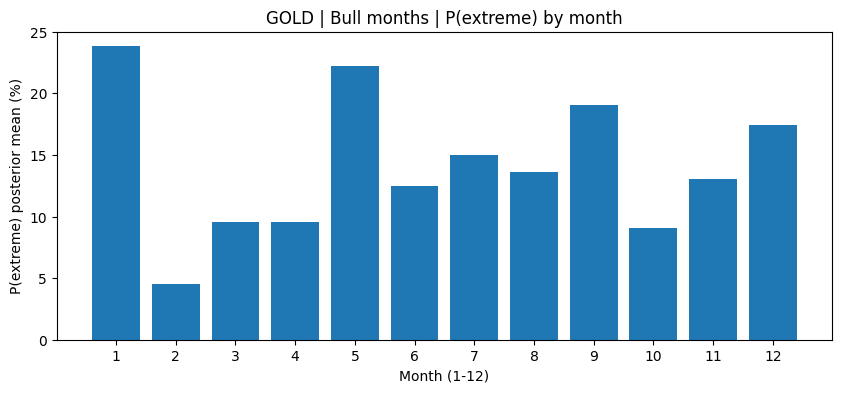

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/3275809482.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)


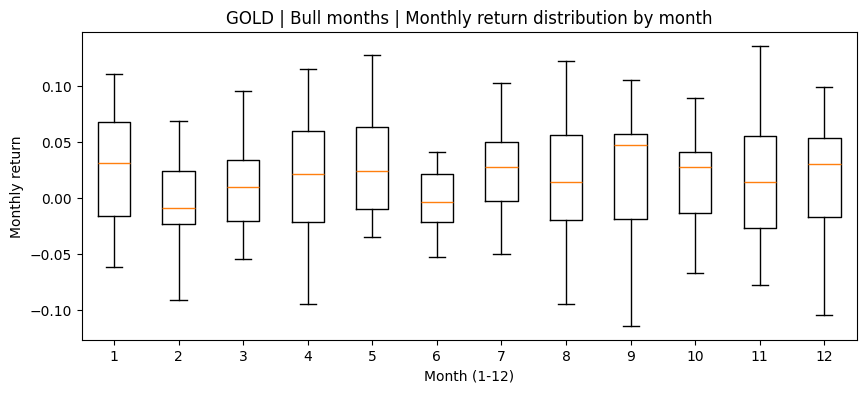

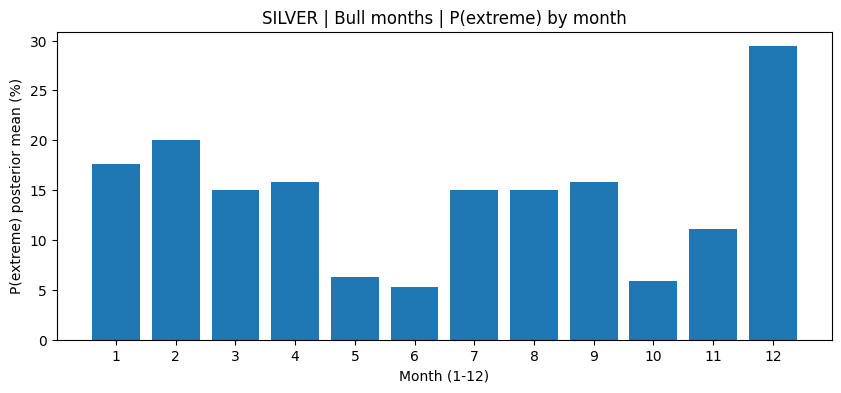

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/3275809482.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)


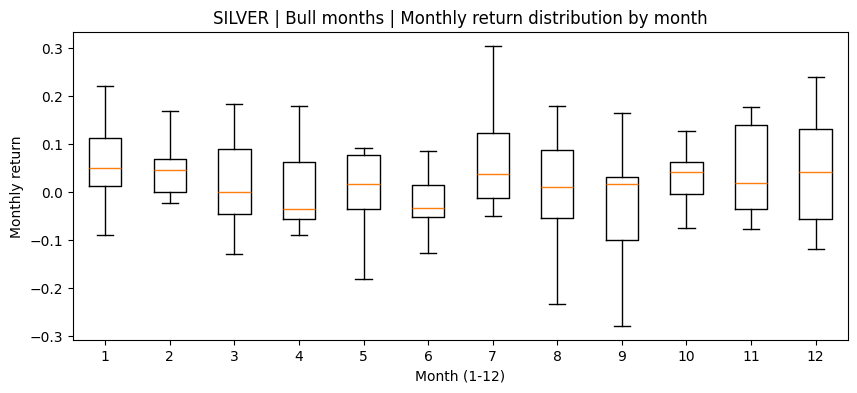

In [6]:
import matplotlib.pyplot as plt

def plot_month_bayes_prob(tbl: pd.DataFrame, title: str, out_path: str | None = None):
    x = tbl["month"].astype(int).values
    y = tbl["bayes_p_mean_%"].values

    plt.figure(figsize=(10, 4))
    plt.bar(x, y)
    plt.xticks(x)
    plt.xlabel("Month (1-12)")
    plt.ylabel("P(extreme) posterior mean (%)")
    plt.title(title)
    if out_path:
        import os
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close()

def plot_month_box(ret_m: pd.Series, bull_mask: pd.Series, title: str, out_path: str | None = None):
    r = ret_m.dropna().copy()
    r.index = pd.DatetimeIndex(r.index).to_period("M").to_timestamp("M")
    bm = bull_mask.reindex(r.index).fillna(False).astype(bool)
    r = r[bm]

    df = pd.DataFrame({"ret": r, "month": r.index.month})
    data = [df.loc[df["month"] == m, "ret"].values for m in range(1, 13)]

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)
    plt.xlabel("Month (1-12)")
    plt.ylabel("Monthly return")
    plt.title(title)
    if out_path:
        import os
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close()

# Example:
gold_ret = to_monthly_returns(gold_price)
silver_ret = to_monthly_returns(silver_price)

plot_month_bayes_prob(gold_bull_tbl, "GOLD | Bull months | P(extreme) by month", "./img/FigX_GOLD_bull_extreme_prob.png")
plot_month_box(gold_ret, gold_bull, "GOLD | Bull months | Monthly return distribution by month", "./img/FigX_GOLD_bull_box.png")

plot_month_bayes_prob(silver_bull_tbl, "SILVER | Bull months | P(extreme) by month", "./img/FigX_SILVER_bull_extreme_prob.png")
plot_month_box(silver_ret, silver_bull, "SILVER | Bull months | Monthly return distribution by month", "./img/FigX_SILVER_bull_box.png")



================ GOLD (DAILY) ================
[Method1 return-quantile] ALL thr=2.80% | events=51 | min_gap=5d
[Method1 return-quantile] BULL thr=2.73% | events=56 | bull_days=3136
[Method2 z-quantile]      ALL thr=2.518 | events=55 | vol_window=63
[Method2 z-quantile]      BULL thr=2.498 | events=56

--- Event probability by month (ALL) | return-quantile ---
 month  n_days  n_events  event_rate_%  bayes_p_mean_% bayes_p_90CI_%  event_mean_ret_%  event_median_ret_%
    11     523         8      1.529637        1.714286   [0.90, 2.73]          3.619522            3.360148
     6     528         7      1.325758        1.509434   [0.75, 2.46]          3.863165            3.705364
     4     517         6      1.160542        1.348748   [0.63, 2.27]          3.274860            3.088832
    10     574         6      1.045296        1.215278   [0.57, 2.05]          3.274195            3.141419
     2     479         4      0.835073        1.039501   [0.41, 1.89]          3.584789         

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:338: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_close_daily = yf.download("GC=F", start="2000-01-01", end="2026-01-12", progress=False)["Close"]
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:341: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_close_daily = yf.download("SI=F", start="2000-01-01", end="2026-01-12", progress=False)["Close"]
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bull_d = bull_m.reindex(me).fillna(False).astype(bool)


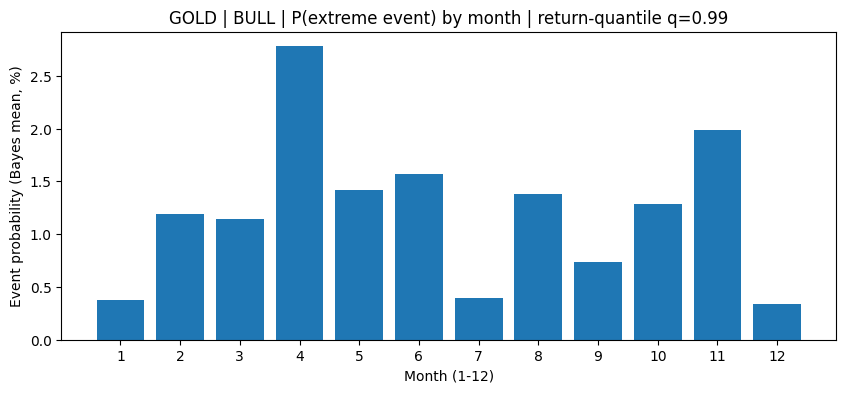

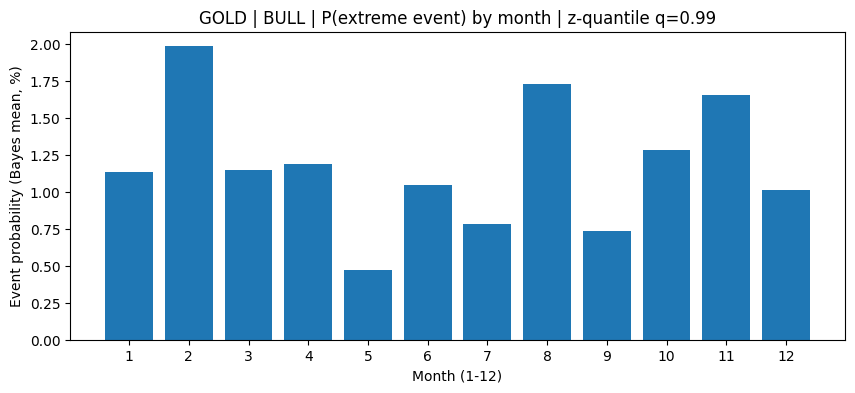

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)


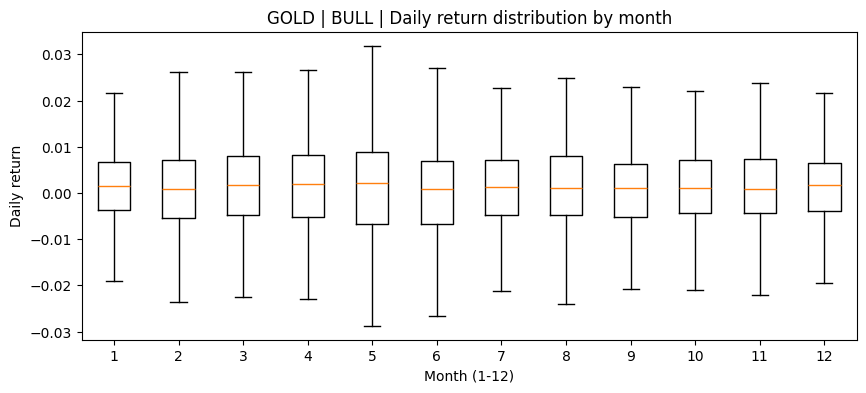


================ SILVER (DAILY) ================
[Method1 return-quantile] ALL thr=5.35% | events=50 | min_gap=5d
[Method1 return-quantile] BULL thr=5.40% | events=47 | bull_days=2574
[Method2 z-quantile]      ALL thr=2.635 | events=59 | vol_window=63
[Method2 z-quantile]      BULL thr=2.551 | events=61

--- Event probability by month (ALL) | return-quantile ---
 month  n_days  n_events  event_rate_%  bayes_p_mean_% bayes_p_90CI_%  event_mean_ret_%  event_median_ret_%
    11     523         9      1.720841        1.904762   [1.04, 2.98]          6.654927            6.577441
    12     544         7      1.286765        1.465201   [0.73, 2.39]          7.092045            6.652172
     7     529         6      1.134216        1.318267   [0.62, 2.22]          6.384234            6.359831
     9     529         5      0.945180        1.129944   [0.50, 1.97]          7.443834            6.189514
    10     574         5      0.871080        1.041667   [0.46, 1.82]          7.488305       

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bull_d = bull_m.reindex(me).fillna(False).astype(bool)


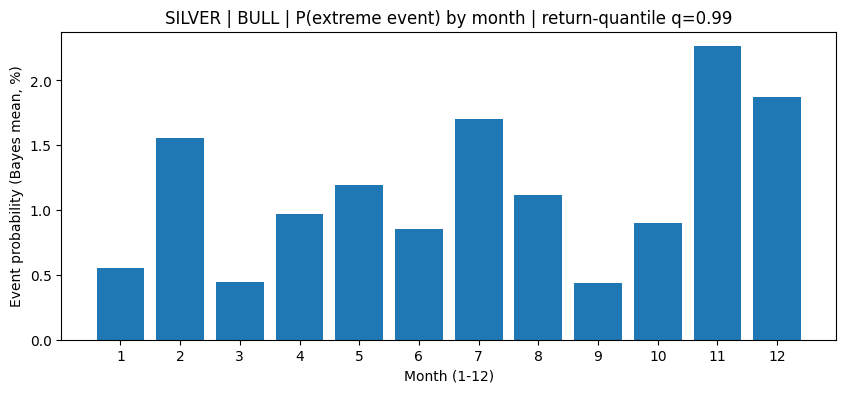

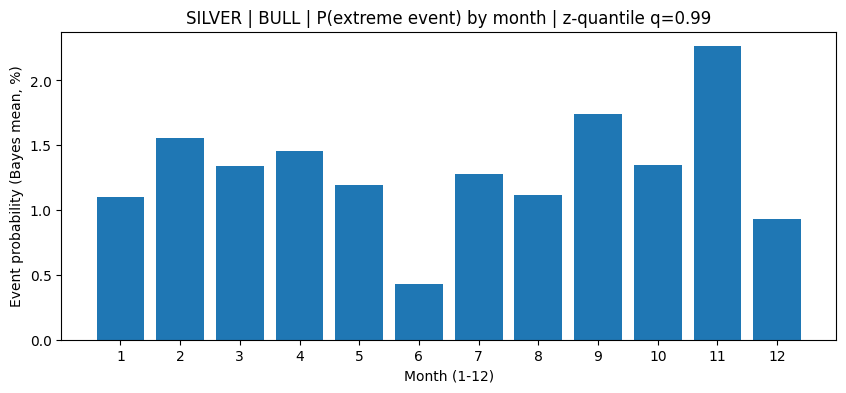

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_20081/1352488392.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)


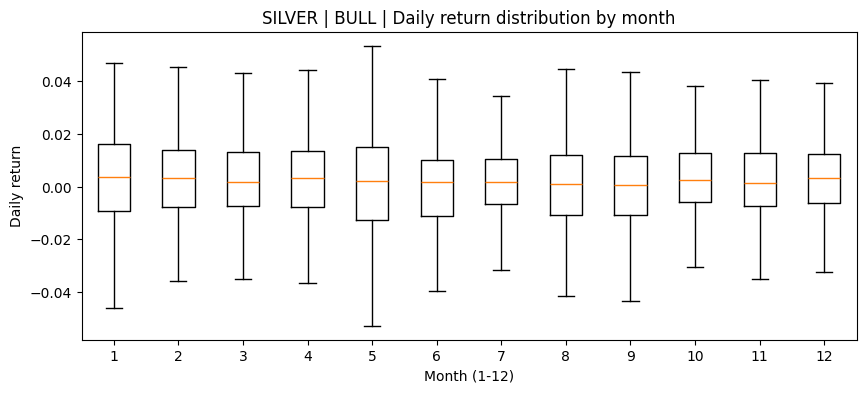

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


# ----------------------------
# 1) Map monthly bull mask (ME index) -> daily bull mask
#    bull_m: Series[bool] indexed by month-end (ME)
# ----------------------------
def map_monthly_bull_to_daily(bull_m: pd.Series, daily_index: pd.DatetimeIndex) -> pd.Series:
    bull_m = bull_m.copy()
    bull_m.index = pd.DatetimeIndex(bull_m.index).to_period("M").to_timestamp("M")
    bull_m = bull_m[~bull_m.index.duplicated(keep="last")].sort_index()

    di = pd.DatetimeIndex(daily_index)
    me = di.to_period("M").to_timestamp("M")
    bull_d = bull_m.reindex(me).fillna(False).astype(bool)
    bull_d.index = di
    return bull_d

# ----------------------------
# 2) Daily returns & z-score
# ----------------------------
def daily_returns(close_d: pd.Series) -> pd.Series:
    c = close_d.dropna().sort_index()
    return c.pct_change()

def zscore_returns(ret_d: pd.Series, vol_window: int = 63) -> pd.Series:
    r = ret_d.dropna().copy()
    vol = r.rolling(vol_window).std()
    z = r / vol
    return z

# ----------------------------
# 3) Declustering: convert extreme days -> "events"
#    Greedy window: within any min_gap trading days, keep only the strongest score.
# ----------------------------
def decluster_events(score: pd.Series, is_extreme: pd.Series, min_gap_days: int = 5) -> pd.DatetimeIndex:
    score = score.dropna()
    is_extreme = is_extreme.reindex(score.index).fillna(False).astype(bool)

    cand = score[is_extreme]
    if cand.empty:
        return pd.DatetimeIndex([])

    idx = cand.index.sort_values()
    selected = []
    i = 0
    while i < len(idx):
        t0 = idx[i]
        # window end by trading-day count (index-based, not calendar days)
        j = i
        # include candidates within next min_gap_days trading days (approx by index positions)
        # To do this, we locate position in full score index.
        pos0 = score.index.get_loc(t0)
        pos_end = min(pos0 + min_gap_days, len(score.index) - 1)
        t_end = score.index[pos_end]

        # candidates within [t0, t_end]
        window_cand = cand.loc[(cand.index >= t0) & (cand.index <= t_end)]
        t_star = window_cand.idxmax()
        selected.append(t_star)

        # advance i to first candidate after t_end
        i = np.searchsorted(idx.values, t_end.to_datetime64(), side="right")

    return pd.DatetimeIndex(selected).unique().sort_values()

# ----------------------------
# 4) Month summary for event probabilities + event strength
# ----------------------------
def beta_ci(k: int, n: int, alpha0: float = 1.0, beta0: float = 1.0, ci=(0.05, 0.95), seed=42):
    a = alpha0 + k
    b = beta0 + (n - k)
    p_mean = a / (a + b)
    rng = np.random.default_rng(seed)
    samp = rng.beta(a, b, size=20000)
    lo, hi = np.quantile(samp, ci)
    return float(p_mean), float(lo), float(hi)

def summarize_events_by_month(
    ret_d: pd.Series,
    event_dates: pd.DatetimeIndex,
    mask: pd.Series | None = None,     # optional: bull-only
    alpha0: float = 1.0,
    beta0: float = 1.0,
) -> pd.DataFrame:
    r = ret_d.dropna().copy()
    if mask is not None:
        mask = mask.reindex(r.index).fillna(False).astype(bool)
        r = r[mask]

    # daily count per month
    month = r.index.month
    days_per_month = r.groupby(month).size()

    # event dates restricted to scope
    ev = pd.DatetimeIndex(event_dates).intersection(r.index)
    ev_month = pd.Series(ev.month, index=ev)
    events_per_month = ev_month.value_counts().sort_index()

    rows = []
    for m in range(1, 13):
        n_days = int(days_per_month.get(m, 0))
        k_ev = int(events_per_month.get(m, 0))
        if n_days == 0:
            continue

        p_mean, p_lo, p_hi = beta_ci(k_ev, n_days, alpha0, beta0)

        # event strength (based on daily return on event day)
        ev_days_m = ev[ev.month == m]
        ev_rets = r.loc[ev_days_m] if len(ev_days_m) else pd.Series(dtype=float)

        rows.append({
            "month": m,
            "n_days": n_days,
            "n_events": k_ev,
            "event_rate_%": 100 * (k_ev / n_days),
            "bayes_p_mean_%": 100 * p_mean,
            "bayes_p_90CI_%": f"[{100*p_lo:.2f}, {100*p_hi:.2f}]",
            "event_mean_ret_%": 100 * (ev_rets.mean() if len(ev_rets) else np.nan),
            "event_median_ret_%": 100 * (ev_rets.median() if len(ev_rets) else np.nan),
        })

    out = pd.DataFrame(rows).sort_values(["bayes_p_mean_%", "event_rate_%"], ascending=False)
    return out

def summarize_returns_by_month(
    ret_d: pd.Series,
    mask: pd.Series | None = None
) -> pd.DataFrame:
    r = ret_d.dropna().copy()
    if mask is not None:
        mask = mask.reindex(r.index).fillna(False).astype(bool)
        r = r[mask]

    month = r.index.month
    g = r.groupby(month)

    out = pd.DataFrame({
        "month": range(1, 13),
    }).set_index("month")

    out["n_days"] = g.size()
    out["mean_daily_%"] = 100 * g.mean()
    out["median_daily_%"] = 100 * g.median()
    out["winrate_%"] = 100 * g.apply(lambda x: (x > 0).mean())
    out["p95_daily_%"] = 100 * g.quantile(0.95)
    out = out.dropna().reset_index().sort_values("mean_daily_%", ascending=False)
    return out

# ----------------------------
# 5) Two extreme definitions
#   A) Quantile on raw daily returns
#   B) Quantile or threshold on z-score returns
# ----------------------------
def extreme_events_quantile(
    ret_d: pd.Series,
    q: float = 0.99,
    scope_mask: pd.Series | None = None,    # if provided, threshold computed within scope
    min_gap_days: int = 5,
):
    r = ret_d.dropna().copy()
    if scope_mask is not None:
        scope_mask = scope_mask.reindex(r.index).fillna(False).astype(bool)
        thr = r[scope_mask].quantile(q)
    else:
        thr = r.quantile(q)

    is_ext = (r >= thr)
    score = r  # use return as score for declustering
    ev = decluster_events(score, is_ext, min_gap_days=min_gap_days)
    return thr, ev

def extreme_events_zscore(
    ret_d: pd.Series,
    vol_window: int = 63,
    q: float | None = 0.99,               # if set, use quantile on z within scope; else use fixed z_thr
    z_thr: float | None = None,
    scope_mask: pd.Series | None = None,
    min_gap_days: int = 5,
):
    r = ret_d.dropna().copy()
    z = zscore_returns(r, vol_window=vol_window).dropna()

    if scope_mask is not None:
        scope_mask = scope_mask.reindex(z.index).fillna(False).astype(bool)
        z_scope = z[scope_mask]
    else:
        z_scope = z

    if z_thr is None:
        if q is None:
            raise ValueError("Provide either q or z_thr.")
        thr = z_scope.quantile(q)
    else:
        thr = z_thr

    is_ext = (z >= thr)
    score = z  # decluster using z magnitude
    ev = decluster_events(score, is_ext, min_gap_days=min_gap_days)
    return thr, ev, z

# ----------------------------
# 6) Plots
# ----------------------------
def plot_event_prob_bar(tbl: pd.DataFrame, title: str, out_path: str | None = None):
    x = tbl["month"].astype(int).values
    y = tbl["bayes_p_mean_%"].values

    plt.figure(figsize=(10, 4))
    plt.bar(x, y)
    plt.xticks(x)
    plt.xlabel("Month (1-12)")
    plt.ylabel("Event probability (Bayes mean, %)")
    plt.title(title)
    # if out_path:
    #     savefig(out_path)
    plt.show()
    plt.close()

def plot_daily_box_by_month(ret_d: pd.Series, mask: pd.Series | None, title: str, out_path: str | None = None):
    r = ret_d.dropna().copy()
    if mask is not None:
        mask = mask.reindex(r.index).fillna(False).astype(bool)
        r = r[mask]

    df = pd.DataFrame({"ret": r, "month": r.index.month})
    data = [df.loc[df["month"] == m, "ret"].values for m in range(1, 13)]

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, labels=list(range(1, 13)), showfliers=False)
    plt.xlabel("Month (1-12)")
    plt.ylabel("Daily return")
    plt.title(title)
    # if out_path:
    #     savefig(out_path)
    plt.show()
    plt.close()

# ----------------------------
# 7) One-click runner: both methods + both scopes (ALL vs BULL)
# ----------------------------
def run_daily_month_study(
    asset_name: str,
    close_d: pd.Series,
    bull_m: pd.Series,
    out_dir: str = "./img",
    q_ret: float = 0.99,            # top 1% daily return
    q_z: float = 0.99,              # top 1% z-score
    vol_window: int = 63,
    min_gap_days: int = 5,
):
    ret = daily_returns(close_d)
    bull_d = map_monthly_bull_to_daily(bull_m, ret.index)

    # --- Method 1: quantile on raw returns ---
    thr_all_ret, ev_all_ret = extreme_events_quantile(ret, q=q_ret, scope_mask=None, min_gap_days=min_gap_days)
    thr_bull_ret, ev_bull_ret = extreme_events_quantile(ret, q=q_ret, scope_mask=bull_d, min_gap_days=min_gap_days)

    tbl_all_ret = summarize_events_by_month(ret, ev_all_ret, mask=None)
    tbl_bull_ret = summarize_events_by_month(ret, ev_bull_ret, mask=bull_d)

    # --- Method 2: quantile on z-score ---
    thr_all_z, ev_all_z, z = extreme_events_zscore(ret, vol_window=vol_window, q=q_z, scope_mask=None, min_gap_days=min_gap_days)
    thr_bull_z, ev_bull_z, _ = extreme_events_zscore(ret, vol_window=vol_window, q=q_z, scope_mask=bull_d, min_gap_days=min_gap_days)

    tbl_all_z = summarize_events_by_month(ret, ev_all_z, mask=None)
    tbl_bull_z = summarize_events_by_month(ret, ev_bull_z, mask=bull_d)

    # --- Month return stats (bull-only) ---
    ret_bull_stats = summarize_returns_by_month(ret, mask=bull_d)

    # Print headline
    print(f"\n================ {asset_name} (DAILY) ================")
    print(f"[Method1 return-quantile] ALL thr={100*thr_all_ret:.2f}% | events={len(ev_all_ret)} | min_gap={min_gap_days}d")
    print(f"[Method1 return-quantile] BULL thr={100*thr_bull_ret:.2f}% | events={len(ev_bull_ret)} | bull_days={(bull_d.reindex(ret.index).sum())}")
    print(f"[Method2 z-quantile]      ALL thr={thr_all_z:.3f} | events={len(ev_all_z)} | vol_window={vol_window}")
    print(f"[Method2 z-quantile]      BULL thr={thr_bull_z:.3f} | events={len(ev_bull_z)}")

    # Show top months
    print("\n--- Event probability by month (ALL) | return-quantile ---")
    print(tbl_all_ret.to_string(index=False))
    print("\n--- Event probability by month (BULL) | return-quantile ---")
    print(tbl_bull_ret.to_string(index=False))

    print("\n--- Event probability by month (ALL) | z-quantile ---")
    print(tbl_all_z.to_string(index=False))
    print("\n--- Event probability by month (BULL) | z-quantile ---")
    print(tbl_bull_z.to_string(index=False))

    print("\n--- Bull-only daily return stats by month ---")
    print(ret_bull_stats.to_string(index=False))

    # Plots (bull-only recommended)
    plot_event_prob_bar(tbl_bull_ret, f"{asset_name} | BULL | P(extreme event) by month | return-quantile q={q_ret}",
                        f"{out_dir}/FigD_{asset_name}_bull_eventprob_retq.png")
    plot_event_prob_bar(tbl_bull_z, f"{asset_name} | BULL | P(extreme event) by month | z-quantile q={q_z}",
                        f"{out_dir}/FigD_{asset_name}_bull_eventprob_zq.png")
    plot_daily_box_by_month(ret, bull_d, f"{asset_name} | BULL | Daily return distribution by month",
                            f"{out_dir}/FigD_{asset_name}_bull_box_daily.png")

    return {
        "ret": ret, "bull_d": bull_d,
        "thr_all_ret": thr_all_ret, "ev_all_ret": ev_all_ret, "tbl_all_ret": tbl_all_ret,
        "thr_bull_ret": thr_bull_ret, "ev_bull_ret": ev_bull_ret, "tbl_bull_ret": tbl_bull_ret,
        "thr_all_z": thr_all_z, "ev_all_z": ev_all_z, "tbl_all_z": tbl_all_z,
        "thr_bull_z": thr_bull_z, "ev_bull_z": ev_bull_z, "tbl_bull_z": tbl_bull_z,
        "ret_bull_stats": ret_bull_stats
    }

# ----------------------------
# USAGE (you provide daily close + your existing monthly bull mask)
# Example:
import yfinance as yf

def ensure_series(x, name: str = "value") -> pd.Series:
    """
    Make sure x is a 1D Series.
    - If DataFrame with 1 column: squeeze to Series
    - If DataFrame with multiple cols: take the first column (or raise if you prefer)
    """
    if isinstance(x, pd.Series):
        return x.dropna()
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            s = x.iloc[:, 0]
        else:
            # 如果你更严谨，可以改成 raise ValueError(...)
            s = x.iloc[:, 0]
        s = s.rename(name)
        return s.dropna()
    # fallback
    return pd.Series(x, name=name).dropna()

gold_close_daily = yf.download("GC=F", start="2000-01-01", end="2026-01-12", progress=False)["Close"]
gold_close_daily = ensure_series(gold_close_daily, "gold_close")

silver_close_daily = yf.download("SI=F", start="2000-01-01", end="2026-01-12", progress=False)["Close"]
silver_close_daily = ensure_series(silver_close_daily, "silver_close")


out_gold = run_daily_month_study("GOLD", gold_close_daily, gold_bull, q_ret=0.99, q_z=0.99, vol_window=63, min_gap_days=5)
out_silver = run_daily_month_study("SILVER", silver_close_daily, silver_bull, q_ret=0.99, q_z=0.99, vol_window=63, min_gap_days=5)
#
# If you want "more extreme", use q_ret=0.995 and/or q_z=0.995
# If you want fewer clustered events, increase min_gap_days (e.g., 10)
# ----------------------------
